<a href="https://colab.research.google.com/github/NivedithaVelaga/product-recommendation-system/blob/main/User_based_collaborative_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#E-commerce Product recommendation System

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import mean_squared_error

## Importing Dataset

In [2]:
#Import the data set
df = pd.read_csv('/ratings_Electronics.csv', header=None) #There are no headers in the data file

df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] #Adding column names

df = df.drop('timestamp', axis=1) #Dropping timestamp

df_copy = df.copy(deep=True) #Copying the data to another dataframe

## EDA - Exploratory Data Analysis

check for -
- shape
- datatype
- missing values


finally get the summary and check
- rating distribution.
- number of users and products.
- Users with highest no of ratings.

In [3]:
rows, columns = df.shape
print("No of rows = ", rows)
print("No of columns = ", columns)

No of rows =  721192
No of columns =  3


### Datatypes

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 721192 entries, 0 to 721191
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  721192 non-null  object 
 1   prod_id  721191 non-null  object 
 2   rating   721191 non-null  float64
dtypes: float64(1), object(2)
memory usage: 16.5+ MB


### Missing value analysis

In [5]:
# Find number of missing values in each column
df.isna().sum()

,0
user_id,0
prod_id,1
rating,1


### Summary

In [6]:
# Summary statistics of 'rating' variable
df['rating'].describe()

,rating
count,721191.000000
mean,3.977192
std,1.397653
min,1.000000
25%,3.000000
50%,5.000000
75%,5.000000
max,5.000000


### Rating distribution

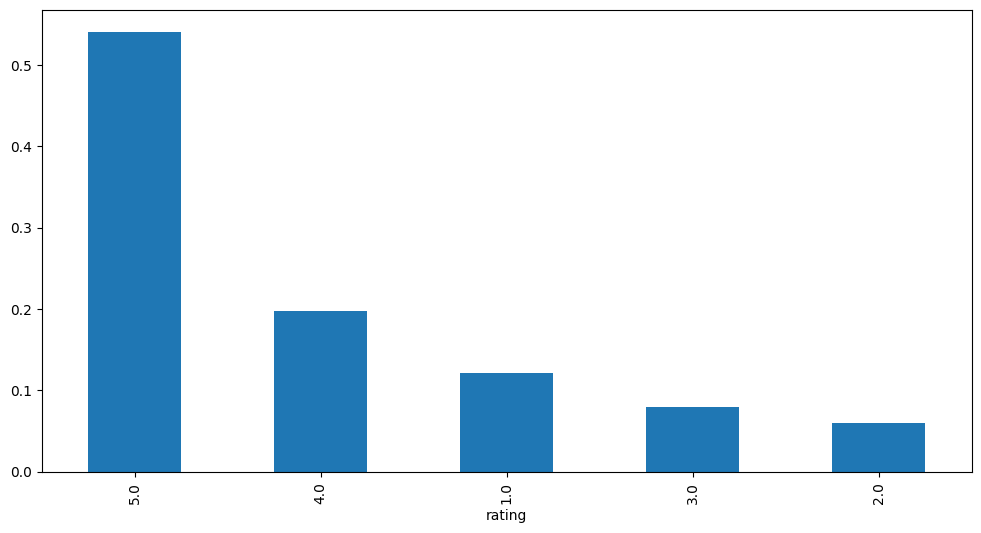

In [7]:
#Create the plot and provide observations

plt.figure(figsize = (12,6))
df['rating'].value_counts(1).plot(kind='bar')
plt.show()

The distribution is skewed to the right. Over 50% of the ratings are 5, followed by a little below 20% with 4 star ratings. And the percentages of ratings keep going down until below 10% of the ratings are 2 stars.

### No of unique users and items

In [8]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df['prod_id'].nunique())

Number of unique USERS in Raw data =  562586
Number of unique ITEMS in Raw data =  43831


### Users with most no of rating

In [9]:
# Top 10 users based on rating
most_rated = df.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated

,0
user_id,
A5JLAU2ARJ0BO,374
A231WM2Z2JL0U3,249
A25HBO5V8S8SEA,163
AT6CZDCP4TRGA,107
A6FIAB28IS79,107
AKT8TGIT6VVZ5,105
A11D1KHM7DVOQK,104
A2B7BUH8834Y6M,96
A2AEZQ3DGBBLPR,81


## Pre-Processing

Let's take a subset of the dataset (by only keeping the users who have given 50 or more ratings) to make the dataset less sparse and easy to work with.

In [10]:
counts = df['user_id'].value_counts()
df_final = df[df['user_id'].isin(counts[counts >= 50].index)]

In [11]:
print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['user_id'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_final['prod_id'].nunique())

The number of observations in the final data = 2380
Number of unique USERS in the final data =  25
Number of unique PRODUCTS in the final data =  2065


- The dataframe **df_final has users who have rated 50 or more items**
- **We will use df_final to build recommendation systems**

In [12]:
#Creating the interaction matrix of products and users based on ratings and replacing NaN value with 0
final_ratings_matrix = df_final.pivot(index = 'user_id', columns ='prod_id', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

#Finding the number of non-zero entries in the interaction matrix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

#Finding the possible number of ratings as per the number of users and products
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

#Density of ratings
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

final_ratings_matrix.head()

Shape of final_ratings_matrix:  (25, 2065)
given_num_of_ratings =  2380
possible_num_of_ratings =  51625
density: 4.61%


prod_id,1400532655,B000000O48,B000001OL6,B000001OMN,B00000J05A,B00000J061,B00000J0E8,B00000J1E6,B00000J1EP,B00000J1G6,...,B000ACHVVE,B000AEFVVE,B000AFW6RA,B000AFY48O,B000AJIF4E,B000AL8JKW,B000ALAFYU,B000AMLXHW,B000ANF8GS,B000ANRP82
user_id,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A12DLJESJKM1OQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A149RNR5RH19YY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
A1F9Z42CFF9IAY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
A1FR68QH6Z4YZM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,5.0,0.0,5.0,0.0,0.0,0.0,0.0


# Collaborative Filtering based Recommendation System

## User based collaborative filtering

In [13]:
final_ratings_matrix.head()

prod_id,1400532655,B000000O48,B000001OL6,B000001OMN,B00000J05A,B00000J061,B00000J0E8,B00000J1E6,B00000J1EP,B00000J1G6,...,B000ACHVVE,B000AEFVVE,B000AFW6RA,B000AFY48O,B000AJIF4E,B000AL8JKW,B000ALAFYU,B000AMLXHW,B000ANF8GS,B000ANRP82
user_id,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A12DLJESJKM1OQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A149RNR5RH19YY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
A1F9Z42CFF9IAY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
A1FR68QH6Z4YZM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,5.0,0.0,5.0,0.0,0.0,0.0,0.0


Here, user_id (index) is of the object data type. We will replace the user_id by numbers starting from 0 to 1539 (for all user ids) so that the index is of integer type and represents a user id in the same format

In [14]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

prod_id,1400532655,B000000O48,B000001OL6,B000001OMN,B00000J05A,B00000J061,B00000J0E8,B00000J1E6,B00000J1EP,B00000J1G6,...,B000ACHVVE,B000AEFVVE,B000AFW6RA,B000AFY48O,B000AJIF4E,B000AL8JKW,B000ALAFYU,B000AMLXHW,B000ANF8GS,B000ANRP82
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,5.0,0.0,5.0,0.0,0.0,0.0,0.0


In [15]:
# defining a function to get similar users
def similar_users(user_index, interactions_matrix):
    similarity = []
    for user in range(0, interactions_matrix.shape[0]): #  .shape[0] gives number of rows

        #finding cosine similarity between the user_id and each user
        sim = cosine_similarity([interactions_matrix.loc[user_index]], [interactions_matrix.loc[user]])

        #Appending the user and the corresponding similarity score with user_id as a tuple
        similarity.append((user,sim))

    similarity.sort(key=lambda x: x[1], reverse=True)
    most_similar_users = [tup[0] for tup in similarity] #Extract the user from each tuple in the sorted list
    similarity_score = [tup[1] for tup in similarity] ##Extracting the similarity score from each tuple in the sorted list

    #Remove the original user and its similarity score and keep only other similar users
    most_similar_users.remove(user_index)
    similarity_score.remove(similarity_score[0])

    return most_similar_users, similarity_score

#### Finding out top 10 similar users to the user index 3 and their similarity score

In [16]:
similar = similar_users(3,final_ratings_matrix)[0][0:10]
similar

[6, 5, 9, 18, 12, 20, 1, 17, 8, 7]

In [17]:
#Print the similarity score
similar_users(3,final_ratings_matrix)[1][0:10]

[array([[0.06382499]]),
 array([[0.0490978]]),
 array([[0.04172781]]),
 array([[0.04119796]]),
 array([[0.0404755]]),
 array([[0.03528972]]),
 array([[0.03190266]]),
 array([[0.02957255]]),
 array([[0.02137567]]),
 array([[0.02049266]])]

#### Finding out top 10 similar users to the user index 1521 and their similarity score

In [20]:
similar = similar_users(4, final_ratings_matrix)[0][0:10]

In [21]:
#Print the similarity score
similar_users(4,final_ratings_matrix)[1][0:10]

[array([[0.0938133]]),
 array([[0.03673613]]),
 array([[0.02112539]]),
 array([[0.01746598]]),
 array([[0.01739334]]),
 array([[0.01662436]]),
 array([[0.01516717]]),
 array([[0.0142208]]),
 array([[0.]]),
 array([[0.]])]

### Function to recommend products

In [22]:
# defining the recommendations function to get recommendations by using the similar users' preferences
def recommendations(user_index, num_of_products, interactions_matrix):

    #Saving similar users using the function similar_users defined above
    most_similar_users = similar_users(user_index, interactions_matrix)[0]

    #Finding product IDs with which the user_id has interacted
    prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[user_index] > 0)]))
    recommendations = []

    observed_interactions = prod_ids.copy()
    for similar_user in most_similar_users:
        if len(recommendations) < num_of_products:

            #Finding 'n' products which have been rated by similar users but not by the user_id
            similar_user_prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user] > 0)]))
            recommendations.extend(list(similar_user_prod_ids.difference(observed_interactions)))
            observed_interactions = observed_interactions.union(similar_user_prod_ids)
        else:
            break

    return recommendations[:num_of_products]

#### Recommend 5 products to user index 3 based on similarity based collaborative filtering

In [23]:
recommendations(3,5,final_ratings_matrix)

['B000059MSI', 'B00006RSIZ', 'B00004ZCDD', 'B00004TX6F', 'B0003QIXBY']

#### Recommend 5 products to user index 1521 based on similarity based collaborative filtering

In [25]:
recommendations(4,5,final_ratings_matrix)

['B00005LEOH', 'B0000TU7I6', 'B0007WK8KS', 'B00006I57Q', 'B0006GQ6K6']